In [48]:
import numpy
import scipy.special

In [49]:
import scipy.ndimage

In [97]:
class neuralNetwork:
    
    def __init__(self, inputNodes, hiddenNodes, outputNodes, learningRate):
        #Колво узлов
        self.inodes = inputNodes
        self.hnodes = hiddenNodes
        self.onodes = outputNodes
        
        #Матрицы весовых коэффицентов
        self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #Коэффицент обучения
        self.lr = learningRate;
        
        #Функция активация: здесь сигмоида 1/(1 + e^-x)
        self.activationFunc = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        pass
    
    def train(self, inputsList, targetsList):
        inputs = numpy.array(inputsList, ndmin=2).T
        targets = numpy.array(targetsList, ndmin=2).T
        
        #Входящие сигналы для скрытого слоя
        hidden_inputs = numpy.dot(self.wih, inputs)
        #Исходящий сигнал из скрытого слоя
        hidden_outputs = self.activationFunc(hidden_inputs)
        
        #Входящий сигнал в выходной слой
        final_inputs = numpy.dot(self.who, hidden_outputs)
        #Выходящий сигнал из выходного слоя
        final_outputs = self.activationFunc(final_inputs)
        
        #Ошибка = целевое значение - фактическое значение
        output_errors = targets - final_outputs
        #Ошибки скрытого слоя
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        #Обновление весовых коэффицентов между скрытым слоем и выходным
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        #Обновление весовых коэффицентов между входным слоем и скрытым
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        pass
    
    def query(self, inputsList):
        inputs = numpy.array(inputsList, ndmin=2).T
        
        #Входящие сигналы для скрытого слоя
        hidden_inputs = numpy.dot(self.wih, inputs)
        #Исходящий сигнал из скрытого слоя
        hidden_outputs = self.activationFunc(hidden_inputs)
        
        
        #Входящий сигнал в выходной слой
        final_inputs = numpy.dot(self.who, hidden_outputs)
        #Выходящий сигнал из выходного слоя
        final_outputs = self.activationFunc(final_inputs)
        
        return final_outputs
    
    def backquery(self, targets_list):
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        final_inputs = self.inverse_activation_function(final_outputs)

        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs   

In [98]:
#Создание сети
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.01

n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [52]:
#Тренировка сети
training_data_file = open("train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [53]:
epochs = 10
for e in range(epochs):  
    for record in training_data_list:
        all_values = record.split(',')
        
        #Целевое значение
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        
        #Оригинльное изображение
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        n.train(inputs, targets)
        
        #Поворот изображения на 10 градусов против часовой
        inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets)
        
        #Поворот изображения на 10 градусов по часовой
        inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets)
    
        pass
    pass

In [54]:
#Тестирование сети
test_data_file = open("test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [100]:
scorecard = [] 

for record in test_data_list:
    all_values = record.split(',')
    correct = int(all_values[0])
    
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    outputs = n.query(inputs)
    
    value = numpy.argmax(outputs)
    
    #print("Число", correct, "распозналось как", value)
    
    if (value == correct):
        scorecard.append(1)
    else: scorecard.append(0)
        
scorecard_array = numpy.asarray(scorecard)
print("Эффективность: ", scorecard_array.sum() / scorecard_array.size)

Эффективность:  0.9761


In [56]:
import csv

In [57]:
#Сохранение весов в csv файл
fileWIH = "wih.csv"
fileWHO = "who.csv"

with open(fileWIH, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(n.wih)
    
with open(fileWHO, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(n.who)

In [99]:
#Извлечение весов из csv файла
with open(fileWIH, "r", newline="") as file:
    reader = csv.reader(file)
    n.wih = numpy.genfromtxt(fileWIH, delimiter=',')
with open(fileWHO, "r", newline="") as file:
    reader = csv.reader(file)
    n.who = numpy.genfromtxt(fileWHO, delimiter=',')

In [63]:
#Cвои изображения
import matplotlib.pyplot
%matplotlib inline

import imageio

min =  0.01
max =  1.0
network says  6


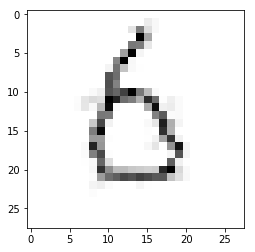

In [126]:
img_array = imageio.imread('Image/6_3.png', as_gray=True)
img_data  = 255.0 - img_array.reshape(784)
img_data = (img_data / 255.0 * 0.99) + 0.01
print("min = ", numpy.min(img_data))
print("max = ", numpy.max(img_data))
matplotlib.pyplot.imshow(img_data.reshape(28,28), cmap='Greys', interpolation='None')

outputs = n.query(img_data)

label = numpy.argmax(outputs)
print("network says ", label)

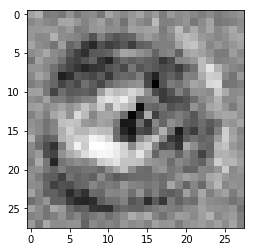

In [127]:
#Представление числа внутри нейросети

#Число
label = 3

targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

image_data = n.backquery(targets)
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')